# Fitting a tophat function to data
# The goal is to detect free-floating planets microlensing events using this function, because they most resemble this function due to finite source effect

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.patches as patches
import random
from matplotlib.lines import Line2D
import scipy.optimize as opt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib.patches import Patch

%matplotlib inline

In [2]:
def med_med (true,fitted):
    temp = fitted - true
    return (np.median(np.abs(temp-np.median(temp))))

In [3]:
# Low-pass filter to smooth out the noise

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [4]:
def calc_chisq(lightcurve,fx):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / fx).sum()
    
    return chisq

In [5]:
def calc_chisq2(lightcurve,fx,ferror):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / (ferror**2)).sum()
    
    return chisq

In [6]:
# ASSUMPTION = t and m are panda dataframes
# Create a function that: 
# 1- Smoothes the lightcurve
# 2- Divides it into bins of arbitrary sizes
# 3- Calculates (m - mean)/std(m)
# 4- Counts the number of outliers in each bin with deviations larger than threshold*sigma

def find_peaks (t, m, smooth='yes', bin_size = 30, threshold = 3):
    
    if smooth == 'yes':
        m = low_pass_filter(m,8)
    else:
        pass
    
    bins = np.linspace(t.min(),t.max(),int((t.max()-t.min())/bin_size))
    groups = df.groupby(np.digitize(t, bins))
    
    std_ = np.std(m)
    delta_m = []
    t__ = []
    c=0
    for i in groups.indices:
        #print c
        c = c+1
        #print i
        m_ = m[groups.indices[i]]
        t_ = t[groups.indices[i]]
        #print t,m
        del_m = np.asarray((np.abs(m_- m_.mean())/std_))
        delta_m.append(del_m)
        t__.append(np.asarray(t_))
        
    n_outliers = []
    t_mean_in_each_bin = []
    for j in range(len(delta_m)):
    
        n_outliers.append(len(np.where(delta_m[j]>threshold)[0])) 
        t_mean_in_each_bin.append(np.mean(t__[j]))
        
    return n_outliers, t_mean_in_each_bin

In [7]:
def tophat_fitter (xdata, ydata, yerr): #ydata is magnitude, baseline of xdata is set on zero
    
    
    # give p0 [t0, tE, am]
    t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,99.95] )[0]])]
    tE_ini = 0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
    am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,99.95] )[0]]) 

    print t0_ini,tE_ini,am_ini


    paramt = [t0_ini, tE_ini, am_ini]
    #paramt = [2456161.49889, 2, -0.08]
    #print paramt



    # optmizing

    nll = lambda *args: -lnlike(*args)
    result = opt.minimize(nll, paramt, args=(np.asarray(xdata),np.asarray(ydata), np.asarray(yerr)),method = 'Nelder-Mead')
    t0_ml, tE_ml, am_ml = result['x']

    print t0_ml, tE_ml, am_ml

    guess    = rect1(xdata,*paramt)
    solution = rect1(xdata,*result['x'])
    
    return t0_ml, tE_ml, am_ml, guess, solution

    

In [8]:
home = os.path.expanduser("~")

In [9]:
direc = os.listdir(home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc')

In [10]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [11]:
'''
Defining the tophat function, a function that has a constant baseline 
except for a short interval at which it has another constant value
# x is the time baseline
# t0 is the time of the center of the tophat
# tE is half of the duration of the tophat
# am is the amplitude of the tophat
'''
def rect1(x,t0, tE, am):
    '''
    x  = time array
    t0 = time of center of the top-hat
    tE = half duration of the top-hat
    am = amplitude
    '''
    x0 = x - t0
    return am*np.where(np.abs(x0)<=tE, 1, 0)






def sinusoid(x, amp, off,P):
    '''
    amp = amplitude
    off = offset
    '''
    x0 = (x-off)
    return amp*np.sin(x0)


def trapezoid(x, a, b, tau1, tau2, tau3, tau4):
    # a and c are slopes
    #tau1 and tau2 mark the beginning and end of the flat top
#     y = np.zeros(len(x))
#     c = -np.abs(c)
#     a = np.abs(a)
#     #(tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
#     y[:int(tau1)] = base
#     y[int(tau1):int(tau2)] =  a*x[:int(tau1)] + b
#     y[int(tau2):int(tau3)] =  a*tau1 + b 
#     y[int(tau2):int(tau4)] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
#     y[int(tau4):] = base

    y = np.zeros(len(x))
    df_trap = pd.DataFrame({'x': x, 'y': y})
    
    c1 = np.abs((b-a)/(tau2-tau1))
    c2 = -1 * np.abs((a-b)/(tau4-tau3))
    
    df_trap['y'][df_trap['x']<tau1] = a
    df_trap['y'][(df_trap['x']>tau1) & (df_trap['x']<tau2)] =  c1*df_trap['x'][(df_trap['x']>tau1) & (df_trap['x']<tau2)] + (a- c1 * tau1)
    df_trap['y'][(df_trap['x']>tau2) & (df_trap['x']<tau3)] =  b
    df_trap['y'][(df_trap['x']>tau3) & (df_trap['x']<tau4)] = c2*df_trap['x'][(df_trap['x']>tau3) & (df_trap['x']<tau4)] + (a- c2 * tau4)
    df_trap['y'][df_trap['x']>tau4] = a

    return df_trap['y']

# calculating the likelihood function

def lnlike(theta, t, f, f_err):
    t0, tE, amp  = theta
    model = rect1(t,t0, tE,amp)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))



In [12]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    #print min(lightcurve)
    #print it0
    return baseline, event, it0

In [13]:
def prepare(t,m,err):
    
    df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': err})
    peaks = np.array([t[np.argmin(m)]])
    baseline, event, it0 = localize_event(df['t'], peaks[0],50)
    
    base_mag = np.median(df['magnitude'][baseline])
    df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))
    
    interpol = interp1d(df['t'],df['A'], kind='cubic')
    dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-1.06))]-peaks[0])
    #print dt
    
    if dt==0.0:
        dt = 50


        
    
    #dt = 50
    baseline, event, it0 = localize_event(df['t'], peaks[0],dt)

    while (np.abs((df['t'][event]).diff())).max() > 0.1:
        
        if dt>20:
            dt = dt - 10
            baseline, event, it0 = localize_event(df['t'], peaks[0],dt)
        else:
            break
    #print dt    
    return df, interpol,baseline, event, it0, dt




In [681]:
name = 'mag.dcnormffp_0_82_162.det.lc.W149'
f = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'+str(name)

In [682]:
# Testing the fit on an OGLE free-floating candidate with a large value of rho

# f = 'data/OGLE_2012_BLG_1323/phot.dat'

In [683]:
t,m,e = np.loadtxt(f,unpack=True, usecols=(0,1, 2))

df, interpol,baseline, event, it0, dt = prepare(t,m,e)

df['magnitude_modified'] = np.median(df['magnitude'][baseline]) - df['magnitude']

xdata = df['t']
ydata = df['magnitude_modified']

t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,100] )[1]])]
#tE_ini1 = 0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,100] )[1]]) 

tE_ini = [10., 1., 0.1, 0.01]

chisqr = []
popt_final = []

for tE_i in tE_ini:


    a, b, tau1, tau2, tau3, tau4 = 0, am_ini, t0_ini-1*tE_i, t0_ini-0.5*tE_i, t0_ini+0.5*tE_i, t0_ini+1*tE_i



    paramt = [a, b, tau1, tau2, tau3, tau4]

    # optmizing
    popt, pcov = opt.curve_fit(trapezoid, xdata, ydata, p0=paramt)

    chisqr.append(calc_chisq2(ydata,trapezoid(xdata, *popt),e))
    popt_final.append(popt)


    chisqr_final = min(chisqr)
    popt = popt_final[np.argmin(chisqr)]

guess    = trapezoid(xdata, *paramt)
solution = trapezoid(xdata, *popt)



In [684]:
guess = np.median(df['magnitude'][baseline])-guess
solution = np.median(df['magnitude'][baseline])-solution



In [685]:
t0_ml = xdata[np.argmin(np.abs(xdata-(popt[2]+(popt[5]-popt[2])/2)))]
tE_ml = (popt[5]-popt[2])
tE_flat = np.abs(popt[4]-popt[3])
tE_flat_ratio = tE_flat/tE_ml
am_ml = popt[1]

In [686]:
print t0_ml-2458234

1620.5398809998296


1.6586947944015265 20.749742601385343


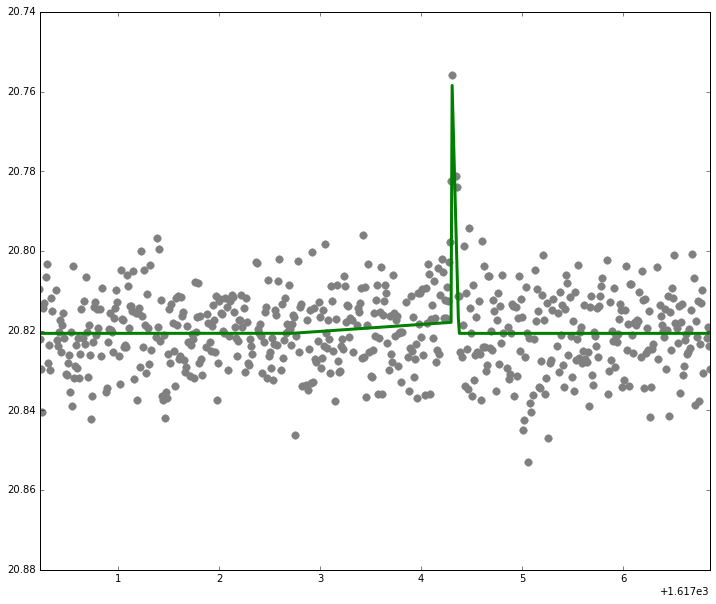

In [687]:
# tE_ini = 0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>3*np.std(ydata))[0])


plt.figure(1)
plt.plot(df['t']-2458234, df['magnitude'],'.',color='grey', markersize = 15)
plt.plot(df['t']-2458234, solution,'g-', linewidth= 3)


plt.xlim(t0_ml-2458234-2*tE_ml, t0_ml-2458234+2*tE_ml)

print tE_ml, tE_flat_ratio

plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)

In [139]:
# #Fitting trapezoid to Data Challenge light curves


# direc.sort()
# result = {'name':[], 't0_ml':[], 'tE_ml':[], 'a':[], 'b':[], 'tau1':[],'tau2':[], 'tau3':[],
#           'tau4':[], 'mag_med':[], 'guess':[], 'solution':[], 'xdata': [], 'ydata': [], 'yerr': [],
#          'second?': []}
# c = 0 

# for f in tqdm(direc):
#     #print f
    
#     if  f.endswith('.W149') and f.startswith('mag.'):
        
#         sec = 0
#         c = c +1
        
#         try:
#             t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))

#             df, interpol,baseline, event, it0, dt = prepare(t,m,e)
            
#             df['magnitude_modified'] = np.median(df['magnitude'][baseline]) - df['magnitude']
            
#             xdata = df['t']
#             ydata = df['magnitude_modified']
            
#             t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,99.95] )[1]])]
#             tE_ini = 0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
#             am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,99.95] )[1]]) 

#             a, b, tau1, tau2, tau3, tau4 = 0, am_ini, t0_ini-1*tE_ini, t0_ini-0.5*tE_ini, t0_ini+0.5*tE_ini, t0_ini+1*tE_ini

#             #print a, b, tau1, tau2, tau3, tau4


#             paramt = [a, b, tau1, tau2, tau3, tau4]

#             # optmizing
#             popt, pcov = opt.curve_fit(trapezoid, xdata, ydata, p0=paramt)
            
            
#             # For very short events, the above setting doesn't work and we add another turn of fits to fix that:
# #             if np.abs(popt[5]-popt[2]) > 0.7:
                
#             t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,100] )[1]])]
#             tE_ini = 0.5 #0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
#             am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,100] )[1]]) 

#             a, b, tau1, tau2, tau3, tau4 = 0, am_ini, t0_ini-1*tE_ini, t0_ini-0.5*tE_ini, t0_ini+0.5*tE_ini, t0_ini+1*tE_ini

#             #print f


#             paramt = [a, b, tau1, tau2, tau3, tau4]

#             # optmizing
                
                
#             popt2, pcov2 = opt.curve_fit(trapezoid, xdata, ydata, p0=paramt)
                
#             if calc_chisq2(ydata,trapezoid(xdata, *popt2),e) < calc_chisq2(ydata,trapezoid(xdata, *popt),e):
                
#                 popt = popt2
#                 sec = 1

#             guess    = trapezoid(xdata, *paramt)
#             solution = trapezoid(xdata, *popt)
            
#             t0_ml = xdata[np.argmin(xdata-((popt[5]-popt[2])/2))]
#             tE_ml = (popt[5]-popt[2])
#             tE_flat = (popt[4]-popt[3])
#             tE_flat_ratio = tE_flat/tE_ml
#             am_ml = popt[1]
            
            
#             result['name'].append(f)
#             result['t0_ml'].append(t0_ml)
#             result['tE_ml'].append(tE_ml)
#             result['a'].append(popt[0])
#             result['b'].append(popt[1])
#             result['tau1'].append(popt[2])
#             result['tau2'].append(popt[3])
#             result['tau3'].append(popt[4])
#             result['tau4'].append(popt[5])
#             result['mag_med'].append(np.median(df['magnitude'][baseline]))
#             result['guess'].append(np.median(df['magnitude'][baseline])-guess)
#             result['solution'].append(np.median(df['magnitude'][baseline])-solution)
#             result['xdata'].append(df['t'])
#             result['ydata'].append(df['magnitude'])
#             result['yerr'].append(df['m_err'])
#             result['second?'].append(sec)
            
#         except (RuntimeError, TypeError, NameError, ValueError):
#             print 'error:'+str(f)
#             pass
# #     if c == 4:
# #         break

# print 'done'








In [66]:
i = 0

for j in range(len(result['name'])):
    
    if result['name'][j] == 'mag.dcnormffp_0_82_581.det.lc.W149':
        
        i = j

print result['name'][i]
print result['t0_ml'][i]-2458234-4390, result['tE_ml'][i]
plt.figure()
plt.title('Fitting a Trapezoidal Function to a FFP Lightcurve', size=25)
plt.xlabel('$t - t_0 (days)$',size=29)
plt.ylabel('$Magnitude$',size=29)
plt.tick_params(axis='y',labelsize=18)
plt.tick_params(axis='x',labelsize=20)
plt.plot(result['xdata'][i]-2454000-4391.2, result['ydata'][i], 'k.', markersize=15)
plt.plot(result['xdata'][i]-2454000-4391.2,result['solution'][i],'g-', linewidth=3)
plt.xlim(-1,1)
plt.gca().invert_yaxis()
fig = plt.gcf()
fig.set_size_inches(12.0,10.0)
# fig.savefig('Trapezoid_FFP.png')

NameError: name 'result' is not defined

In [22]:
info1 = pd.read_csv('ombin.CSV')
info2 = pd.read_csv('omcassan.CSV')
info3 = pd.read_csv('dccv.CSV')
info4 = pd.read_csv('dcnormffp.CSV')

In [23]:
frames = [info1, info2, info3, info4]

info = pd.concat(frames)

In [24]:
info['tE_trapezoid'] = np.zeros(len(info))
info['t0_trapezoid'] = np.zeros(len(info))
info['baseline_trapezoid'] = np.zeros(len(info))
info['max_trapezoid'] = np.zeros(len(info))
info['tau1'] = np.zeros(len(info))
info['tau2'] = np.zeros(len(info))
info['tau3'] = np.zeros(len(info))
info['tau4'] = np.zeros(len(info))
info['second?'] = np.zeros(len(info))
info['baseline_magnitude_median'] = np.zeros(len(info))
info['chisqr_trapezoid'] = np.zeros(len(info))
info['reduced_chisqr'] = np.zeros(len(info))





In [25]:
info = info.rename(columns={"index": "name"})

In [26]:
for i in range(len(result['name'])):

    if result['name'][i].split('.lc')[0].endswith('all'): 
        result['name'][i] = result['name'][i].split('all')[0]+'det'+result['name'][i].split('all')[1]

In [28]:

for i in tqdm(range(len(result['name']))):
     
    
    info.loc[info.name == result['name'][i], 'tE_trapezoid'] = result['tE_ml'][i]
    info.loc[info.name == result['name'][i], 'baseline_trapezoid'] = result['a'][i]
    info.loc[info.name == result['name'][i], 'max_trapezoid'] = result['b'][i]
    info.loc[info.name == result['name'][i], 't0_trapezoid'] = result['t0_ml'][i]
    info.loc[info.name == result['name'][i], 'tau1'] = result['tau1'][i]
    info.loc[info.name == result['name'][i], 'tau2'] = result['tau2'][i]
    info.loc[info.name == result['name'][i], 'tau3'] = result['tau3'][i]
    info.loc[info.name == result['name'][i], 'tau4'] = result['tau4'][i]
    info.loc[info.name == result['name'][i], 'second?'] = result['second?'][i]
    info.loc[info.name == result['name'][i], 'baseline_magnitude_median'] = result['mag_med'][i]
    info.loc[info.name == result['name'][i], 'chisqr_trapezoid'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])
    info.loc[info.name == result['name'][i], 'reduced_chisqr'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])/(len(result['ydata'][i])-7)


    
    if not result['name'][i] in info.name.values:
        print result['name'][i]

 79%|███████▉  | 3681/4649 [03:32<00:55, 17.32it/s]

mag.omcassan_0_100_1197.det.lc.W149
mag.omcassan_0_100_3114.det.lc.W149


 79%|███████▉  | 3685/4649 [03:32<00:55, 17.32it/s]

mag.omcassan_0_100_66.det.lc.W149


 79%|███████▉  | 3691/4649 [03:33<00:55, 17.32it/s]

mag.omcassan_0_10_1228.det.lc.W149


 80%|███████▉  | 3703/4649 [03:33<00:54, 17.31it/s]

mag.omcassan_0_21_2040.det.lc.W149
mag.omcassan_0_21_414.det.lc.W149


 80%|███████▉  | 3707/4649 [03:34<00:54, 17.31it/s]

mag.omcassan_0_22_3213.det.lc.W149


 80%|████████  | 3721/4649 [03:35<00:53, 17.30it/s]

mag.omcassan_0_34_1491.det.lc.W149
mag.omcassan_0_35_2018.det.lc.W149


 80%|████████  | 3729/4649 [03:35<00:53, 17.30it/s]

mag.omcassan_0_44_669.det.lc.W149
mag.omcassan_0_46_400.det.lc.W149


 80%|████████  | 3735/4649 [03:35<00:52, 17.29it/s]

mag.omcassan_0_48_1719.det.lc.W149
mag.omcassan_0_49_1633.det.lc.W149


 80%|████████  | 3739/4649 [03:36<00:52, 17.29it/s]

mag.omcassan_0_58_1019.det.lc.W149


 80%|████████  | 3741/4649 [03:36<00:52, 17.29it/s]

mag.omcassan_0_59_1633.det.lc.W149
mag.omcassan_0_59_2013.det.lc.W149


 81%|████████  | 3747/4649 [03:36<00:52, 17.29it/s]

mag.omcassan_0_61_1201.det.lc.W149
mag.omcassan_0_61_384.det.lc.W149
mag.omcassan_0_61_681.det.lc.W149
mag.omcassan_0_63_316.det.lc.W149


 81%|████████  | 3751/4649 [03:37<00:51, 17.28it/s]

mag.omcassan_0_6_1191.det.lc.W149


 81%|████████  | 3755/4649 [03:37<00:51, 17.28it/s]

mag.omcassan_0_71_259.det.lc.W149


 81%|████████  | 3771/4649 [03:38<00:50, 17.28it/s]

mag.omcassan_0_7_534.det.lc.W149
mag.omcassan_0_83_241.det.lc.W149
mag.omcassan_0_84_720.det.lc.W149


 81%|████████  | 3777/4649 [03:38<00:50, 17.28it/s]

mag.omcassan_0_86_2143.det.lc.W149
mag.omcassan_0_86_2152.det.lc.W149
mag.omcassan_0_87_1718.det.lc.W149


 81%|████████▏ | 3781/4649 [03:38<00:50, 17.28it/s]

mag.omcassan_0_87_2127.det.lc.W149
mag.omcassan_0_88_2050.det.lc.W149


 81%|████████▏ | 3785/4649 [03:39<00:50, 17.28it/s]

mag.omcassan_0_89_114.det.lc.W149


 82%|████████▏ | 3791/4649 [03:39<00:49, 17.28it/s]

mag.omcassan_0_97_1005.det.lc.W149
mag.omcassan_0_97_964.det.lc.W149
mag.omcassan_0_98_1251.det.lc.W149


 82%|████████▏ | 3795/4649 [03:39<00:49, 17.28it/s]

mag.omcassan_0_98_1412.det.lc.W149
mag.omcassan_0_99_1601.det.lc.W149


 82%|████████▏ | 3803/4649 [03:40<00:48, 17.28it/s]

mag.omcassan_10_18_463.det.lc.W149


 82%|████████▏ | 3809/4649 [03:40<00:48, 17.28it/s]

mag.omcassan_10_44_787.det.lc.W149
mag.omcassan_10_47_126.det.lc.W149
mag.omcassan_10_50_253.det.lc.W149


 82%|████████▏ | 3813/4649 [03:40<00:48, 17.28it/s]

mag.omcassan_10_5_594.det.lc.W149
mag.omcassan_10_6_423.det.lc.W149


 82%|████████▏ | 3819/4649 [03:40<00:48, 17.28it/s]

mag.omcassan_10_72_1307.det.lc.W149
mag.omcassan_10_73_847.det.lc.W149


 82%|████████▏ | 3825/4649 [03:41<00:47, 17.28it/s]

mag.omcassan_10_89_385.det.lc.W149
mag.omcassan_10_98_148.det.lc.W149


 83%|████████▎ | 3839/4649 [03:42<00:46, 17.28it/s]

mag.omcassan_1_110_551.det.lc.W149


 83%|████████▎ | 3843/4649 [03:42<00:46, 17.28it/s]

mag.omcassan_1_111_474.det.lc.W149
mag.omcassan_1_112_1070.det.lc.W149
mag.omcassan_1_112_65.det.lc.W149


 83%|████████▎ | 3847/4649 [03:42<00:46, 17.28it/s]

mag.omcassan_1_113_1809.det.lc.W149


 83%|████████▎ | 3855/4649 [03:43<00:45, 17.28it/s]

mag.omcassan_1_11_182.det.lc.W149
mag.omcassan_1_18_442.det.lc.W149
mag.omcassan_1_18_674.det.lc.W149


 83%|████████▎ | 3861/4649 [03:43<00:45, 17.28it/s]

mag.omcassan_1_20_288.det.lc.W149
mag.omcassan_1_20_979.det.lc.W149
mag.omcassan_1_23_1262.det.lc.W149


 83%|████████▎ | 3865/4649 [03:43<00:45, 17.28it/s]

mag.omcassan_1_23_1397.det.lc.W149
mag.omcassan_1_23_990.det.lc.W149


 83%|████████▎ | 3869/4649 [03:43<00:45, 17.28it/s]

mag.omcassan_1_31_529.det.lc.W149


 83%|████████▎ | 3879/4649 [03:44<00:44, 17.28it/s]

mag.omcassan_1_48_1401.det.lc.W149


 84%|████████▎ | 3883/4649 [03:44<00:44, 17.28it/s]

mag.omcassan_1_57_2109.det.lc.W149


 84%|████████▎ | 3891/4649 [03:45<00:43, 17.28it/s]

mag.omcassan_1_5_2403.det.lc.W149
mag.omcassan_1_5_2609.det.lc.W149
mag.omcassan_1_60_992.det.lc.W149


 84%|████████▍ | 3895/4649 [03:45<00:43, 17.28it/s]

mag.omcassan_1_62_1260.det.lc.W149
mag.omcassan_1_63_1559.det.lc.W149


 84%|████████▍ | 3901/4649 [03:45<00:43, 17.28it/s]

mag.omcassan_1_70_1516.det.lc.W149


 84%|████████▍ | 3905/4649 [03:45<00:43, 17.28it/s]

mag.omcassan_1_73_1372.det.lc.W149


 84%|████████▍ | 3911/4649 [03:46<00:42, 17.28it/s]

mag.omcassan_1_75_1206.det.lc.W149
mag.omcassan_1_75_250.det.lc.W149


 84%|████████▍ | 3921/4649 [03:46<00:42, 17.28it/s]

mag.omcassan_1_84_1418.det.lc.W149
mag.omcassan_1_89_1387.det.lc.W149
mag.omcassan_1_89_1625.det.lc.W149


 84%|████████▍ | 3925/4649 [03:47<00:41, 17.28it/s]

mag.omcassan_1_89_565.det.lc.W149


 85%|████████▍ | 3931/4649 [03:47<00:41, 17.28it/s]

mag.omcassan_1_98_479.det.lc.W149


 85%|████████▍ | 3943/4649 [03:48<00:40, 17.28it/s]

mag.omcassan_2_10_214.det.lc.W149
mag.omcassan_2_110_1013.det.lc.W149
mag.omcassan_2_110_1407.det.lc.W149
mag.omcassan_2_110_2700.det.lc.W149


 85%|████████▍ | 3949/4649 [03:48<00:40, 17.28it/s]

mag.omcassan_2_112_3277.det.lc.W149


 85%|████████▌ | 3955/4649 [03:48<00:40, 17.28it/s]

mag.omcassan_2_115_1010.det.lc.W149


 85%|████████▌ | 3961/4649 [03:49<00:39, 17.28it/s]

mag.omcassan_2_20_1425.det.lc.W149
mag.omcassan_2_20_253.det.lc.W149


 85%|████████▌ | 3967/4649 [03:49<00:39, 17.27it/s]

mag.omcassan_2_24_1036.det.lc.W149
mag.omcassan_2_31_1443.det.lc.W149
mag.omcassan_2_31_37.det.lc.W149


 85%|████████▌ | 3971/4649 [03:49<00:39, 17.27it/s]

mag.omcassan_2_31_832.det.lc.W149
mag.omcassan_2_33_54.det.lc.W149


 86%|████████▌ | 3983/4649 [03:50<00:38, 17.27it/s]

mag.omcassan_2_50_216.det.lc.W149
mag.omcassan_2_50_726.det.lc.W149


 86%|████████▌ | 3987/4649 [03:50<00:38, 17.27it/s]

mag.omcassan_2_58_1579.det.lc.W149


 86%|████████▌ | 4005/4649 [03:51<00:37, 17.26it/s]

mag.omcassan_2_76_219.det.lc.W149


 86%|████████▋ | 4019/4649 [03:52<00:36, 17.26it/s]

mag.omcassan_2_87_970.det.lc.W149
mag.omcassan_2_88_1615.det.lc.W149
mag.omcassan_2_96_1919.det.lc.W149


 87%|████████▋ | 4025/4649 [03:53<00:36, 17.26it/s]

mag.omcassan_2_98_1355.det.lc.W149
mag.omcassan_3_101_1518.det.lc.W149


 87%|████████▋ | 4037/4649 [03:53<00:35, 17.27it/s]

mag.omcassan_3_10_404.det.lc.W149
mag.omcassan_3_10_486.det.lc.W149
mag.omcassan_3_10_628.det.lc.W149


 87%|████████▋ | 4041/4649 [03:53<00:35, 17.27it/s]

mag.omcassan_3_110_1304.det.lc.W149


 87%|████████▋ | 4051/4649 [03:54<00:34, 17.27it/s]

mag.omcassan_3_11_2077.det.lc.W149
mag.omcassan_3_11_3148.det.lc.W149
mag.omcassan_3_18_3023.det.lc.W149


 87%|████████▋ | 4059/4649 [03:54<00:34, 17.27it/s]

mag.omcassan_3_20_1560.det.lc.W149
mag.omcassan_3_20_1641.det.lc.W149


 87%|████████▋ | 4065/4649 [03:55<00:33, 17.28it/s]

mag.omcassan_3_21_3178.det.lc.W149


 88%|████████▊ | 4071/4649 [03:55<00:33, 17.28it/s]

mag.omcassan_3_24_1912.det.lc.W149
mag.omcassan_3_31_677.det.lc.W149


 88%|████████▊ | 4075/4649 [03:55<00:33, 17.27it/s]

mag.omcassan_3_33_976.det.lc.W149


 88%|████████▊ | 4081/4649 [03:56<00:32, 17.27it/s]

mag.omcassan_3_49_397.det.lc.W149


 88%|████████▊ | 4091/4649 [03:56<00:32, 17.28it/s]

mag.omcassan_3_60_1155.det.lc.W149
mag.omcassan_3_60_610.det.lc.W149
mag.omcassan_3_61_1090.det.lc.W149


 88%|████████▊ | 4101/4649 [03:57<00:31, 17.28it/s]

mag.omcassan_3_70_2948.det.lc.W149


 88%|████████▊ | 4105/4649 [03:57<00:31, 17.28it/s]

mag.omcassan_3_72_1843.det.lc.W149
mag.omcassan_3_72_2269.det.lc.W149


 89%|████████▊ | 4115/4649 [03:58<00:30, 17.29it/s]

mag.omcassan_3_75_2250.det.lc.W149
mag.omcassan_3_76_472.det.lc.W149


 89%|████████▊ | 4119/4649 [03:58<00:30, 17.29it/s]

mag.omcassan_3_83_382.det.lc.W149
mag.omcassan_3_84_119.det.lc.W149


 89%|████████▉ | 4127/4649 [03:58<00:30, 17.29it/s]

mag.omcassan_3_86_862.det.lc.W149
mag.omcassan_3_87_49.det.lc.W149


 89%|████████▉ | 4135/4649 [03:59<00:29, 17.29it/s]

mag.omcassan_3_89_51.det.lc.W149
mag.omcassan_3_89_57.det.lc.W149
mag.omcassan_3_96_1862.det.lc.W149


 89%|████████▉ | 4141/4649 [03:59<00:29, 17.29it/s]

mag.omcassan_3_97_694.det.lc.W149


 89%|████████▉ | 4146/4649 [03:59<00:29, 17.30it/s]

mag.omcassan_3_9_165.det.lc.W149
mag.omcassan_4_100_282.det.lc.W149


 89%|████████▉ | 4152/4649 [04:00<00:28, 17.30it/s]

mag.omcassan_4_100_393.det.lc.W149


 89%|████████▉ | 4156/4649 [04:00<00:28, 17.30it/s]

mag.omcassan_4_102_2853.det.lc.W149
mag.omcassan_4_102_369.det.lc.W149


 89%|████████▉ | 4160/4649 [04:00<00:28, 17.30it/s]

mag.omcassan_4_111_506.det.lc.W149
mag.omcassan_4_112_1245.det.lc.W149


 90%|████████▉ | 4164/4649 [04:00<00:28, 17.30it/s]

mag.omcassan_4_112_585.det.lc.W149


 90%|████████▉ | 4172/4649 [04:01<00:27, 17.31it/s]

mag.omcassan_4_115_3069.det.lc.W149
mag.omcassan_4_115_510.det.lc.W149


 90%|████████▉ | 4178/4649 [04:01<00:27, 17.31it/s]

mag.omcassan_4_18_1719.det.lc.W149


 90%|████████▉ | 4184/4649 [04:01<00:26, 17.31it/s]

mag.omcassan_4_20_1994.det.lc.W149


 90%|█████████ | 4190/4649 [04:02<00:26, 17.31it/s]

mag.omcassan_4_22_1056.det.lc.W149
mag.omcassan_4_22_117.det.lc.W149


 90%|█████████ | 4198/4649 [04:02<00:26, 17.31it/s]

mag.omcassan_4_32_2432.det.lc.W149
mag.omcassan_4_32_2978.det.lc.W149
mag.omcassan_4_34_1702.det.lc.W149


 90%|█████████ | 4204/4649 [04:02<00:25, 17.31it/s]

mag.omcassan_4_35_120.det.lc.W149
mag.omcassan_4_36_1502.det.lc.W149


 91%|█████████ | 4208/4649 [04:03<00:25, 17.32it/s]

mag.omcassan_4_45_2664.det.lc.W149
mag.omcassan_4_46_1589.det.lc.W149


 91%|█████████ | 4212/4649 [04:03<00:25, 17.32it/s]

mag.omcassan_4_48_1128.det.lc.W149
mag.omcassan_4_48_41.det.lc.W149
mag.omcassan_4_49_18.det.lc.W149


 91%|█████████ | 4218/4649 [04:03<00:24, 17.32it/s]

mag.omcassan_4_50_713.det.lc.W149
mag.omcassan_4_57_3017.det.lc.W149


 91%|█████████ | 4226/4649 [04:03<00:24, 17.32it/s]

mag.omcassan_4_58_965.det.lc.W149
mag.omcassan_4_59_1960.det.lc.W149


 91%|█████████ | 4232/4649 [04:04<00:24, 17.32it/s]

mag.omcassan_4_5_2136.det.lc.W149
mag.omcassan_4_5_2998.det.lc.W149
mag.omcassan_4_5_3035.det.lc.W149


 91%|█████████ | 4238/4649 [04:04<00:23, 17.32it/s]

mag.omcassan_4_61_1408.det.lc.W149
mag.omcassan_4_61_1697.det.lc.W149
mag.omcassan_4_61_418.det.lc.W149


 91%|█████████▏| 4248/4649 [04:05<00:23, 17.33it/s]

mag.omcassan_4_71_388.det.lc.W149


 92%|█████████▏| 4256/4649 [04:05<00:22, 17.33it/s]

mag.omcassan_4_76_1183.det.lc.W149
mag.omcassan_4_7_1120.det.lc.W149
mag.omcassan_4_7_1389.det.lc.W149
mag.omcassan_4_7_2334.det.lc.W149


 92%|█████████▏| 4261/4649 [04:05<00:22, 17.33it/s]

mag.omcassan_4_85_882.det.lc.W149
mag.omcassan_4_86_3148.det.lc.W149
mag.omcassan_4_88_147.det.lc.W149


 92%|█████████▏| 4267/4649 [04:06<00:22, 17.34it/s]

mag.omcassan_4_89_26.det.lc.W149


 92%|█████████▏| 4276/4649 [04:06<00:21, 17.34it/s]

mag.omcassan_4_98_2078.det.lc.W149
mag.omcassan_4_99_747.det.lc.W149


 92%|█████████▏| 4291/4649 [04:07<00:20, 17.35it/s]

mag.omcassan_5_109_1444.det.lc.W149


 93%|█████████▎| 4302/4649 [04:07<00:19, 17.35it/s]

mag.omcassan_5_115_1345.det.lc.W149


 93%|█████████▎| 4313/4649 [04:08<00:19, 17.36it/s]

mag.omcassan_5_20_827.det.lc.W149


 93%|█████████▎| 4321/4649 [04:08<00:18, 17.36it/s]

mag.omcassan_5_22_702.det.lc.W149
mag.omcassan_5_24_2829.det.lc.W149


 93%|█████████▎| 4326/4649 [04:09<00:18, 17.36it/s]

mag.omcassan_5_31_1788.det.lc.W149
mag.omcassan_5_32_2780.det.lc.W149
mag.omcassan_5_32_901.det.lc.W149
mag.omcassan_5_33_1030.det.lc.W149


 93%|█████████▎| 4333/4649 [04:09<00:18, 17.37it/s]

mag.omcassan_5_33_2063.det.lc.W149
mag.omcassan_5_33_494.det.lc.W149
mag.omcassan_5_35_1368.det.lc.W149


 93%|█████████▎| 4338/4649 [04:09<00:17, 17.37it/s]

mag.omcassan_5_36_594.det.lc.W149


 94%|█████████▎| 4347/4649 [04:10<00:17, 17.37it/s]

mag.omcassan_5_48_2673.det.lc.W149


 94%|█████████▎| 4353/4649 [04:10<00:17, 17.38it/s]

mag.omcassan_5_58_943.det.lc.W149
mag.omcassan_5_59_364.det.lc.W149
mag.omcassan_5_59_423.det.lc.W149


 94%|█████████▍| 4359/4649 [04:10<00:16, 17.38it/s]

mag.omcassan_5_59_58.det.lc.W149


 94%|█████████▍| 4367/4649 [04:11<00:16, 17.38it/s]

mag.omcassan_5_63_1267.det.lc.W149


 94%|█████████▍| 4373/4649 [04:11<00:15, 17.39it/s]

mag.omcassan_5_70_1893.det.lc.W149
mag.omcassan_5_72_771.det.lc.W149


 94%|█████████▍| 4376/4649 [04:11<00:15, 17.39it/s]

mag.omcassan_5_73_1293.det.lc.W149
mag.omcassan_5_76_1362.det.lc.W149


 94%|█████████▍| 4382/4649 [04:11<00:15, 17.39it/s]

mag.omcassan_5_86_510.det.lc.W149


 94%|█████████▍| 4388/4649 [04:12<00:15, 17.40it/s]

mag.omcassan_5_96_2508.det.lc.W149
mag.omcassan_5_98_680.det.lc.W149


 95%|█████████▍| 4397/4649 [04:12<00:14, 17.40it/s]

mag.omcassan_6_100_449.det.lc.W149
mag.omcassan_6_101_674.det.lc.W149
mag.omcassan_6_109_1439.det.lc.W149


 95%|█████████▍| 4403/4649 [04:12<00:14, 17.40it/s]

mag.omcassan_6_110_1017.det.lc.W149
mag.omcassan_6_113_876.det.lc.W149


 95%|█████████▍| 4409/4649 [04:13<00:13, 17.41it/s]

mag.omcassan_6_18_778.det.lc.W149
mag.omcassan_6_19_780.det.lc.W149
mag.omcassan_6_21_1422.det.lc.W149


 95%|█████████▍| 4415/4649 [04:13<00:13, 17.41it/s]

mag.omcassan_6_22_143.det.lc.W149
mag.omcassan_6_31_1211.det.lc.W149
mag.omcassan_6_32_1161.det.lc.W149


 95%|█████████▌| 4424/4649 [04:14<00:12, 17.42it/s]

mag.omcassan_6_37_515.det.lc.W149
mag.omcassan_6_44_718.det.lc.W149


 95%|█████████▌| 4430/4649 [04:14<00:12, 17.42it/s]

mag.omcassan_6_48_1044.det.lc.W149
mag.omcassan_6_48_138.det.lc.W149


 95%|█████████▌| 4439/4649 [04:14<00:12, 17.43it/s]

mag.omcassan_6_61_1145.det.lc.W149
mag.omcassan_6_63_275.det.lc.W149
mag.omcassan_6_6_1121.det.lc.W149
mag.omcassan_6_6_1314.det.lc.W149


 96%|█████████▌| 4445/4649 [04:15<00:11, 17.43it/s]

mag.omcassan_6_71_1009.det.lc.W149
mag.omcassan_6_73_1158.det.lc.W149
mag.omcassan_6_74_46.det.lc.W149
mag.omcassan_6_74_69.det.lc.W149


 96%|█████████▌| 4451/4649 [04:15<00:11, 17.43it/s]

mag.omcassan_6_83_728.det.lc.W149


 96%|█████████▌| 4463/4649 [04:15<00:10, 17.44it/s]

mag.omcassan_6_9_342.det.lc.W149
mag.omcassan_6_9_665.det.lc.W149


 96%|█████████▌| 4469/4649 [04:16<00:10, 17.44it/s]

mag.omcassan_7_109_476.det.lc.W149
mag.omcassan_7_10_1028.det.lc.W149
mag.omcassan_7_110_397.det.lc.W149


 96%|█████████▋| 4483/4649 [04:16<00:09, 17.45it/s]

mag.omcassan_7_18_1025.det.lc.W149
mag.omcassan_7_18_1395.det.lc.W149


 97%|█████████▋| 4489/4649 [04:17<00:09, 17.45it/s]

mag.omcassan_7_19_321.det.lc.W149


 97%|█████████▋| 4507/4649 [04:18<00:08, 17.47it/s]

mag.omcassan_7_35_1480.det.lc.W149
mag.omcassan_7_35_1849.det.lc.W149


 97%|█████████▋| 4513/4649 [04:18<00:07, 17.47it/s]

mag.omcassan_7_45_1506.det.lc.W149
mag.omcassan_7_46_132.det.lc.W149
mag.omcassan_7_47_674.det.lc.W149


 97%|█████████▋| 4525/4649 [04:18<00:07, 17.47it/s]

mag.omcassan_7_61_349.det.lc.W149
mag.omcassan_7_6_217.det.lc.W149


 97%|█████████▋| 4531/4649 [04:19<00:06, 17.48it/s]

mag.omcassan_7_70_805.det.lc.W149
mag.omcassan_7_76_1006.det.lc.W149


 98%|█████████▊| 4539/4649 [04:19<00:06, 17.48it/s]

mag.omcassan_7_86_1057.det.lc.W149


 98%|█████████▊| 4545/4649 [04:19<00:05, 17.48it/s]

mag.omcassan_8_111_1331.det.lc.W149
mag.omcassan_8_112_591.det.lc.W149


 98%|█████████▊| 4551/4649 [04:20<00:05, 17.48it/s]

mag.omcassan_8_11_1083.det.lc.W149
mag.omcassan_8_11_432.det.lc.W149
mag.omcassan_8_20_529.det.lc.W149


 98%|█████████▊| 4557/4649 [04:20<00:05, 17.49it/s]

mag.omcassan_8_23_988.det.lc.W149
mag.omcassan_8_24_844.det.lc.W149
mag.omcassan_8_24_947.det.lc.W149


 98%|█████████▊| 4563/4649 [04:20<00:04, 17.49it/s]

mag.omcassan_8_36_245.det.lc.W149


 98%|█████████▊| 4572/4649 [04:21<00:04, 17.50it/s]

mag.omcassan_8_50_222.det.lc.W149


 98%|█████████▊| 4575/4649 [04:21<00:04, 17.50it/s]

mag.omcassan_8_61_714.det.lc.W149


 99%|█████████▊| 4581/4649 [04:21<00:03, 17.50it/s]

mag.omcassan_8_75_1283.det.lc.W149


 99%|█████████▊| 4587/4649 [04:22<00:03, 17.50it/s]

mag.omcassan_8_83_234.det.lc.W149
mag.omcassan_8_8_1306.det.lc.W149
mag.omcassan_8_96_617.det.lc.W149


 99%|█████████▉| 4594/4649 [04:22<00:03, 17.51it/s]

mag.omcassan_9_100_1029.det.lc.W149
mag.omcassan_9_109_347.det.lc.W149
mag.omcassan_9_110_116.det.lc.W149


 99%|█████████▉| 4603/4649 [04:22<00:02, 17.51it/s]

mag.omcassan_9_112_145.det.lc.W149


 99%|█████████▉| 4609/4649 [04:23<00:02, 17.51it/s]

mag.omcassan_9_24_504.det.lc.W149
mag.omcassan_9_24_563.det.lc.W149
mag.omcassan_9_31_743.det.lc.W149


 99%|█████████▉| 4621/4649 [04:23<00:01, 17.52it/s]

mag.omcassan_9_46_840.det.lc.W149


100%|█████████▉| 4630/4649 [04:24<00:01, 17.53it/s]

mag.omcassan_9_59_130.det.lc.W149
mag.omcassan_9_5_426.det.lc.W149
mag.omcassan_9_60_557.det.lc.W149


100%|█████████▉| 4645/4649 [04:24<00:00, 17.53it/s]

mag.omcassan_9_84_1101.det.lc.W149


100%|██████████| 4649/4649 [04:25<00:00, 17.54it/s]

mag.omcassan_9_89_499.det.lc.W149
mag.omcassan_9_99_932.det.lc.W149


In [29]:
info = info.reset_index()

In [30]:
info['name'][0]

'mag.ombin_0_0_9.det.lc.W149'

In [31]:
info['type'] = np.zeros(len(info))

for i in tqdm(range(len(info))):
    
    if info['name'][i].split('mag')[1].startswith('.ombin'):
        
        info.set_value(i, 'type', 1)
        
    if info['name'][i].split('mag')[1].startswith('.dccv'):
        
        info.set_value(i, 'type', 0)
        
    if info['name'][i].split('mag')[1].startswith('.dcnormffp'):
        
        info.set_value(i, 'type', 3)
        
    if info['name'][i].split('mag')[1].startswith('.omcassan'):
        
        info.set_value(i, 'type', 2)

 30%|██▉       | 1408/4770 [00:00<00:00, 14072.80it/s]/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
100%|██████████| 4770/4770 [00:00<00:00, 13082.97it/s]


In [46]:
# info.to_csv('Trapezoidal_all_lc.CSV')

In [17]:
info = pd.read_csv('test_result/Trapezoid/Trapezoidal_PSPL_Results.CSV')

In [507]:
# fitting Trapezoidal function to only PSPL light curves


direc.sort()
result = {'name':[], 't0_ml':[], 'tE_ml':[], 'a':[], 'b':[], 'tau1':[],'tau2':[], 'tau3':[],
          'tau4':[], 'mag_med':[], 'guess':[], 'solution':[], 'xdata': [], 'ydata': [], 'yerr': [],
         'chisqr': []}
c = 0 
up_lim = 100 #99.95

for f in tqdm(direc):
    #print f
    
    if  f.endswith('.W149') and f.split('ag')[1].startswith('.dcnormffp'):#f.endswith('.txt') and f.split('_')[2].startswith('W'):
        
        #print f
        sec = 0
        c = c +1
        
#         try:
        t,m,e = np.loadtxt(temp+str(f),unpack=True, usecols=(0,1, 2))

        df, interpol,baseline, event, it0, dt = prepare(t,m,e)

        df['magnitude_modified'] = np.median(df['magnitude'][baseline]) - df['magnitude']

        xdata = df['t']
        ydata = df['magnitude_modified']

        t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,up_lim] )[1]])]
        #tE_ini1 = 0.5*(xdata.values[1]-xdata.values[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
        am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,up_lim] )[1]]) 

        tE_ini = [10., 1., 0.1, 0.01]
        
        chisqr = []
        popt_final = []
        
        for tE_i in tE_ini:
            
            
            a, b, tau1, tau2, tau3, tau4 = 0, am_ini, t0_ini-1*tE_i, t0_ini-0.5*tE_i, t0_ini+0.5*tE_i, t0_ini+1*tE_i



            paramt = [a, b, tau1, tau2, tau3, tau4]

            # optmizing
            popt, pcov = opt.curve_fit(trapezoid, xdata, ydata, p0=paramt)
            
            chisqr.append(calc_chisq2(ydata,trapezoid(xdata, *popt),e))
            popt_final.append(popt)


            chisqr_final = min(chisqr)
            popt = popt_final[np.argmin(chisqr)]

        guess    = trapezoid(xdata, *paramt)
        solution = trapezoid(xdata, *popt)

        t0_ml = xdata[np.argmin(np.abs(xdata-(popt[2]+(popt[5]-popt[2])/2)))]
        tE_ml = (popt[5]-popt[2])
        tE_flat = (popt[4]-popt[3])
        tE_flat_ratio = tE_flat/tE_ml
        am_ml = popt[1]


        result['name'].append(f)
        result['t0_ml'].append(t0_ml)
        result['tE_ml'].append(tE_ml)
        result['a'].append(popt[0])
        result['b'].append(popt[1])
        result['tau1'].append(popt[2])
        result['tau2'].append(popt[3])
        result['tau3'].append(popt[4])
        result['tau4'].append(popt[5])
        result['mag_med'].append(np.median(df['magnitude'][baseline]))
        result['guess'].append(np.median(df['magnitude'][baseline])-guess)
        result['solution'].append(np.median(df['magnitude'][baseline])-solution)
        result['xdata'].append(df['t'])
        result['ydata'].append(df['magnitude'])
        result['yerr'].append(df['m_err'])
        result['chisqr'].append(chisqr_final)

#         except (RuntimeError, TypeError, NameError, ValueError):
#             print 'error:'+str(f)
#             pass
#     if c == 4:
#         break

print 'done'




100%|██████████| 273/273 [23:53<00:00,  5.25s/it]

done


In [511]:

for i in tqdm(range(len(result['name']))):
     
    
    temp_info.loc[temp_info.name == result['name'][i], 'tE_trapezoid'] = result['tE_ml'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'tau1'] = result['tau1'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'tau2'] = result['tau2'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'tau3'] = result['tau3'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'tau4'] = result['tau4'][i]
    temp_info.loc[temp_info.name == result['name'][i], 't0_trapezoid'] = result['t0_ml'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'a_trapezoid'] = result['a'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'b_trapezoid'] = result['b'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'mag_med'] = result['mag_med'][i]
    temp_info.loc[temp_info.name == result['name'][i], 'chi_squared'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])
    temp_info.loc[temp_info.name == result['name'][i], 'reduced_chi_squared'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])/(len(result['ydata'][i])-7)
    
    if not result['name'][i] in temp_info.name.values:
        print result['name'][i]

100%|██████████| 273/273 [00:10<00:00, 24.84it/s]


In [512]:
temp_info['tE_trapezoid_ratio'] = (temp_info.tau3 - temp_info.tau2)/(temp_info.tau4- temp_info.tau1)

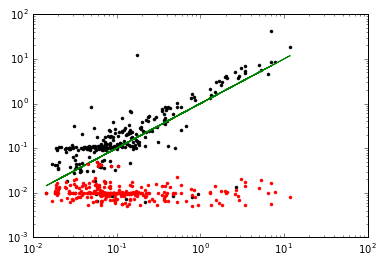

In [521]:
# plt.plot(temp_info.tE_trapezoid, temp_info.tE_trapezoid_ratio, 'b.')
plt.plot(temp_info.tE, temp_info.tE_trapezoid/2., 'k.')
plt.plot(temp_info.tE, temp_info.tE, 'g-')
plt.plot(info.tE[(info.tE_trapezoid <0.1) & (info.tE_trapezoid != 0)], 
         info.tE_trapezoid[(info.tE_trapezoid <0.1) & (info.tE_trapezoid != 0)]/2., 'r.')



plt.xscale('log')
plt.yscale('log')

In [523]:

for i in tqdm(range(len(temp_info.name))):
     
    
    info.loc[info.name == temp_info.name[i], 'tE_trapezoid'] = temp_info['tE_trapezoid'][i]
    info.loc[info.name == temp_info.name[i], 'tE_trapezoid_ratio'] = temp_info['tE_trapezoid_ratio'][i]
    info.loc[info.name == temp_info.name[i], 'tau1'] = temp_info['tau1'][i]
    info.loc[info.name == temp_info.name[i], 'tau2'] = temp_info['tau2'][i]
    info.loc[info.name == temp_info.name[i], 'tau3'] = temp_info['tau3'][i]
    info.loc[info.name == temp_info.name[i], 'tau4'] = temp_info['tau4'][i]
    info.loc[info.name == temp_info.name[i], 't0_trapezoid'] = temp_info['t0_trapezoid'][i]
    info.loc[info.name == temp_info.name[i], 'a_trapezoid'] = temp_info['a_trapezoid'][i]
    info.loc[info.name == temp_info.name[i], 'b_trapezoid'] = temp_info['b_trapezoid'][i]
    info.loc[info.name == temp_info.name[i], 'mag_med'] = temp_info['mag_med'][i]
    info.loc[info.name == temp_info.name[i], 'chi_squared'] = temp_info['chi_squared'][i]
    info.loc[info.name == temp_info.name[i], 'reduced_chi_squared'] = temp_info['reduced_chi_squared'][i]
    

100%|██████████| 273/273 [00:10<00:00, 25.45it/s]


In [70]:
info2 = pd.read_csv('answer_keys/dcnormffp.CSV')

In [51]:
info['tE_trapezoid'] = np.zeros(len(info))
info['tau1'] = np.zeros(len(info))
info['tau2'] = np.zeros(len(info))
info['tau3'] = np.zeros(len(info))
info['tau4'] = np.zeros(len(info))
info['mag_med'] = np.zeros(len(info))
info['a_trapezoid'] = np.zeros(len(info))
info['b_trapezoid'] = np.zeros(len(info))
info['reduced_chi_squared'] = np.zeros(len(info))
info['chi_squared'] = np.zeros(len(info))


In [433]:
t = result['xdata'][2]

In [449]:
for i in range (len(info.name)):
    
    info.loc[info.index == i, 't0_trapezoid'] = t[np.argmin(np.abs(t-(info['tau1'][i]+(info['tau4'][i]-info['tau1'][i])/2)))]-2458234

In [52]:
info = info.rename(columns={"index": "name"})

In [53]:
for i in range(len(result['name'])):

    if result['name'][i].split('.lc')[0].endswith('all'): 
        result['name'][i] = result['name'][i].split('all')[0]+'det'+result['name'][i].split('all')[1]

In [54]:

for i in tqdm(range(len(result['name']))):
     
    
    info.loc[info.name == result['name'][i], 'tE_trapezoid'] = result['tE_ml'][i]
    info.loc[info.name == result['name'][i], 'tau1'] = result['tau1'][i]
    info.loc[info.name == result['name'][i], 'tau2'] = result['tau2'][i]
    info.loc[info.name == result['name'][i], 'tau3'] = result['tau3'][i]
    info.loc[info.name == result['name'][i], 'tau4'] = result['tau4'][i]
    info.loc[info.name == result['name'][i], 't0_trapezoid'] = result['t0_ml'][i]
    info.loc[info.name == result['name'][i], 'a_trapezoid'] = result['a'][i]
    info.loc[info.name == result['name'][i], 'b_trapezoid'] = result['b'][i]
    info.loc[info.name == result['name'][i], 'mag_med'] = result['mag_med'][i]
    info.loc[info.name == result['name'][i], 'chi_squared'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])
    info.loc[info.name == result['name'][i], 'reduced_chi_squared'] = calc_chisq2(result['ydata'][i], result['solution'][i], result['yerr'][i])/(len(result['ydata'][i])-7)
    
    if not result['name'][i] in info.name.values:
        print result['name'][i]

100%|██████████| 1642/1642 [01:08<00:00, 24.10it/s]


In [56]:
info['tE_trapezoid_ratio'] = (info.tau3 - info.tau2)/(info.tau4- info.tau1)

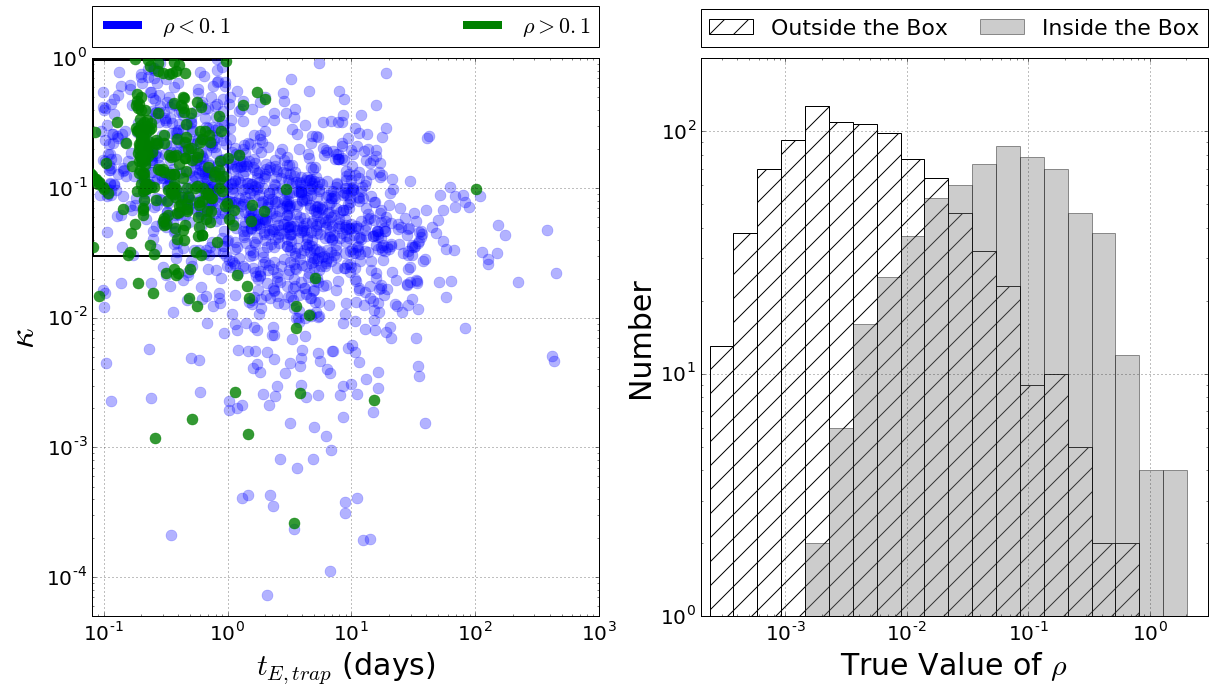

In [20]:
fig, axs = plt.subplots(1, 2)

c = 0.5
b = 1#2458234
rho_lim = 0.1
tE_trap_lim = 2
kappa_lim = 0.03
legend_elements = []

axs[0].plot(c*info['tE_trapezoid'][(info.rho<rho_lim)&(info.tE_trapezoid>0)&(np.abs(info.tE_trapezoid_ratio)<1)],
         np.abs(info['tE_trapezoid_ratio'][(info.rho<rho_lim)&(info.tE_trapezoid>0)&(np.abs(info.tE_trapezoid_ratio)<1)]),
         '.',color= 'blue', markersize=22,alpha = 0.3, label = r'$\rho<0.1$')
# axs[0].plot(info['tE'][(info.tE_trapezoid !=0)],
#          np.abs(info['tE_trapezoid_ratio'][(info.tE_trapezoid !=0)]),
#          'k.', markersize=22,alpha = 0.3, label = 'All lc')
axs[0].plot(info['tE_trapezoid'][(info.rho>rho_lim)&(info.tE_trapezoid >0)&(np.abs(info.tE_trapezoid_ratio)<1)],
         np.abs(info['tE_trapezoid_ratio'][(info.rho>rho_lim) & (info.tE_trapezoid >0)& (np.abs(info.tE_trapezoid_ratio)<1)]),
         '.',color='green', markersize=22,alpha = 0.8, label = r'$\rho>0.1$')
legend_elements.append(Line2D([0], [0], lw=8, color = 'b' , label = r'$\rho<0.1$'))

# axs[0].plot(c*info['tE_trapezoid'][(info.tE_trapezoid>0.1)&(np.abs(info.tE_trapezoid_ratio)>kappa_lim)&(info.tE_trapezoid<tE_trap_lim)&(np.abs(info.tE_trapezoid_ratio)<1)],
#          np.abs(info['tE_trapezoid_ratio'][(info.tE_trapezoid>0.1)&(np.abs(info.tE_trapezoid_ratio)>kappa_lim)&(info.tE_trapezoid<tE_trap_lim)&(np.abs(info.tE_trapezoid_ratio)<1)]),
#          'g.', markersize=22,alpha=0.6, label = '$tE_{trap}\;<\;1 \; Days$')
# axs[0].axvline(tE_trap_lim/2, color = 'black', linewidth = 3)


legend_elements.append(Line2D([0], [0], lw=8, color = 'g', label = r'$\rho>0.1$'))


axs[0].grid()
axs[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),handles=legend_elements, loc='lower left',
           ncol=2, mode="expand", borderaxespad=0. ,prop={'size': 22})

rect = patches.Rectangle((0.082,0.03), 0.92, 0.94, linewidth=2 ,edgecolor='k',facecolor='none')
axs[0].add_patch(rect)

axs[0].set_xlabel('$t_{E,trap}$'+' (days)', size = 30)
axs[0].set_ylabel('$ \kappa$', size = 36)

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[0].set_ylim(5e-5, 1)
axs[0].set_xlim(0.08, 1e3)


legend_elements = []




axs[1].hist(info['rho'][(info.tE_trapezoid>0.1)&(np.abs(info.tE_trapezoid_ratio)<1)&\
                        ((np.abs(info.tE_trapezoid_ratio)<kappa_lim)|(info.tE_trapezoid>tE_trap_lim))],\
                          bins=np.logspace(np.log10(1e-5), np.log10(5), 30),color = 'white', hatch='/',\
                          label='Outside the Box')

legend_elements.append(Patch(facecolor='white', edgecolor='k',hatch = '/',
                         label='Outside the Box')) #Line2D([0], [0], lw=8, color = 'white' ,edgecolor = 'black', label = '$tE_{trap}\;>\;1 \; Days$'))


axs[1].hist(info['rho'][(info.tE_trapezoid>0.1)&(np.abs(info.tE_trapezoid_ratio)<1)&\
                        (np.abs(info.tE_trapezoid_ratio)>kappa_lim)&(info.tE_trapezoid<tE_trap_lim) ],\
                        bins=np.logspace(np.log10(1e-5), np.log10(5), 30), color = 'grey', 
                        label='Inside the Box', alpha = 0.4)

legend_elements.append(Patch(facecolor='grey', edgecolor='k',
                         label='Inside the Box', alpha =0.4))#Line2D([0], [0], lw=8, color = 'grey' , label= '$tE_{trap}<\;1\; \; Days$'))



axs[1].grid()
axs[1].legend(bbox_to_anchor=(0., 1.02, 1., .102),handles=legend_elements, loc='lower left',
           ncol=2, mode="expand", borderaxespad=0. ,prop={'size': 22})

axs[1].set_xlabel('True Value of '+r'$\rho$', size = 30)
axs[1].set_ylabel('Number', size = 30)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.2, hspace=0.08) 

axs[1].set_ylim(1, 200)
axs[1].set_xlim(2e-4, 3)



axs[0].tick_params(axis='both',which='both', labelsize=20)
axs[1].tick_params(axis='both',which='both', labelsize=20)

plt.xscale('log')
plt.yscale('log')


fig = plt.gcf()
fig.set_size_inches(20.0,10.0)
fig.savefig('test_result/Trapezoid/rho_of_tE_less_than_1_V3.png')

In [648]:
(info[['name','rho','tE','tE_trapezoid']][ (info.tE_trapezoid>0.1)&(np.abs(info.tE_trapezoid_ratio)<1)&((np.abs(info.tE_trapezoid_ratio)<kappa_lim)|(info.tE_trapezoid>tE_trap_lim))&(info.rho>0.3)] )

,name,rho,tE,tE_trapezoid
748,mag.dcnormffp_0_82_748.det.lc.W149,0.540243,0.897282,3.461219
1169,mag.dcnormffp_0_82_1169.det.lc.W149,0.478099,0.973918,3.596862


0.882075471698
0.024395153000864374


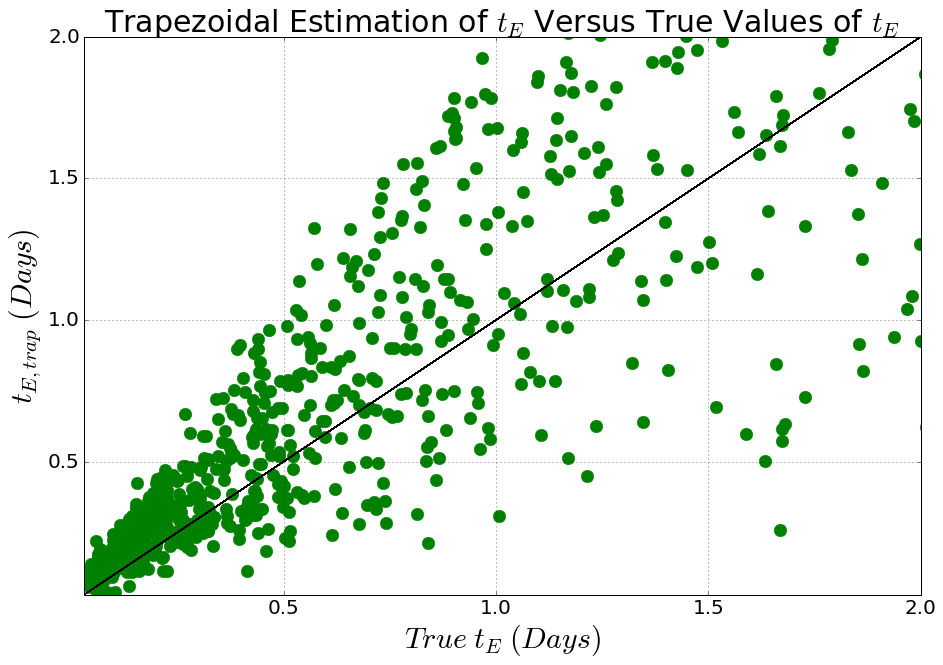

In [96]:
# General format for plotting different parameters versus each other 

plt.figure()
ax = plt.gca()
x = 'tE'
y = 'tE_trapezoid'
C =0.5
#plt.plot(np.abs(info[x][info.tE_trapezoid>2]), np.abs(info[y][info.tE_trapezoid>2]),'r.', markersize=25)


plt.plot(np.abs(info[x][ (info.tE_trapezoid !=0) & (np.abs(info.t0-info.t0_exp)<10)]), C*np.abs(info[y][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)]),'g.', markersize=25)
plt.plot(np.abs(info[x][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)]), np.abs(info[x][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)]),'k-', markersize=25)
# plt.plot(np.abs(info[x][(info.tE<2)& (info.tE_trapezoid >0) & (np.abs(info.t0-info.t0_exp)>10)]), np.abs(info[y][(info.tE<2)& (info.tE_trapezoid >0)& (np.abs(info.t0-info.t0_exp)>10)]),'r.', markersize=25)



# plt.plot(np.abs(info[x]), np.abs(info[x])+0.05,'k-', markersize=25)
# plt.plot(np.abs(info[x]), np.abs(info[x])-0.05,'k-', markersize=25)



# plt.plot(np.abs(info[x][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]), 
#          C*np.abs(info[y][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]),'b.', markersize=25)


print (float(len(info[y][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & 
                         (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & 
                         (info.tE_trapezoid !=0)]))/float(len(info[y][(info.tE<0.1)& (info.tE_trapezoid !=0)])))

print med_med( np.abs(info[x][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]),
             C*np.abs(info[y][(info.tE<0.1) & (np.abs(info.tE_trapezoid/4.)<(np.abs(info.tE)+0.05)) & (np.abs(info.tE_trapezoid/4.)>(np.abs(info.tE)-0.05)) & (info.tE_trapezoid !=0)]))
# axs[0, 1].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
# axs[0, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off',length=0)

plt.gca().tick_params(axis='y',which='both', labelsize=20)
plt.gca().tick_params(axis='x',which='both', labelsize=20)


# axs[1, 0].tick_params(axis='both',which='both', labelsize=12)
# axs[1, 1].tick_params(axis='x',which='both', labelsize=12)

# plt.yscale('log')
# plt.xscale('log')

# ax.set_xticklabels( ['', 0.5, 1.0, 1.5,2.0],rotation = 0, fontsize = 22)
# ax.set_yticklabels( ['',0.5, 0.1,1.5,2.0,2.5,3],rotation = 90, fontsize = 22)


# axs[0, 0].tick_params(axis='x',which='both', bottom='off', top='off',labelbottom='off')
# axs[1, 1].tick_params(axis='y',which='both', bottom='right', top='left',labelleft='off', length=0)

plt.xlim(0.03,2)
plt.ylim(0.03,2)

plt.grid()

# plt.axvline(0.17)
# plt.axhline(0.3)


plt.title('Trapezoidal Estimation of $t_E$ Versus True Values of $t_E$', size=30) 

plt.xlabel('$True \; t_E \; (Days)$',size=30)
plt.ylabel( '$t_{E,trap} \; (Days)$',size=30)

fig = plt.gcf()
fig.set_size_inches(15.0,10.0)
# fig.savefig('tE_FFP_Trapezoid_log_scale.png')

In [693]:
# info[['name', 'tE', 'tE_trapezoid','tE_trapezoid_ratio']][(info.tE<0.2) & (info.tE_trapezoid>0.5)& (np.abs(info.t0-info.t0_exp)>10)]

In [671]:
info.loc[info.name == 'mag.dcnormffp_0_82_1541.det.lc.W149', 'tE_trapezoid'] = 0.22833129903301597       
info.loc[info.name == 'mag.dcnormffp_0_82_1541.det.lc.W149', 'tE_trapezoid_ratio'] = 0.08987250870971625

In [74]:
# info.to_csv('test_result/Tophat:Trapezoid/Trapezoidal_PSPL_Results.CSV')

In [95]:
info = pd.read_csv('test_result/Tophat:Trapezoid/Trapezoidal_PSPL_Results.CSV')

In [689]:
med_med(np.abs(info[x][ (info.tE_trapezoid !=0) & (np.abs(info.t0-info.t0_exp)<10)]),
       C*np.abs(info[y][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)]))

0.45936001273006205

In [690]:
med_med(np.abs(info[x][ (info.tE_trapezoid !=0) & (np.abs(info.t0-info.t0_exp)<10) & (info.tE_trapezoid<1)]),
       C*np.abs(info[y][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)& (info.tE_trapezoid<1)]))

0.06260338371684851

In [691]:
med_med(np.abs(info[x][ (info.tE_trapezoid !=0) & (np.abs(info.t0-info.t0_exp)<10) & (info.tE_trapezoid>1)]),
       C*np.abs(info[y][ (info.tE_trapezoid != 0)& (np.abs(info.t0-info.t0_exp)<10)& (info.tE_trapezoid>1)]))

0.8209994192967578

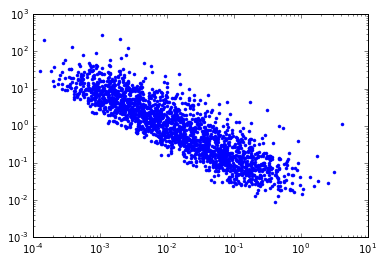

In [81]:
plt.plot(info['rho'], info['tE'],'b.')
plt.xscale('log')
plt.yscale('log')